#### Project Purpose

Telecommunications organizations often suffer from a loss of revenue due to customers choosing to terminate their services. According to the data consideration provided with the dataset, telecommunications companies experience customer churn at a rate of approximately 25% per year. This results in a loss of revenue as it cost approximately ten times more to acquire a new customer than to keep an existing customer.

I will use a time-series analysis to answer the question "What does the projected revenue trend look like in the next year?"

My goals for this time series are to:
1. Explore the data for structure and content.
2. Make necessary transformations.
3. Find a model that gives the most accurate fit to the data.
4. Use the model to forecast predicted revenue for the following year.

#### Assumptions

To perform a time series analysis, the following assumptions are made about the data:
1. The data must be stationary - The distribution of the data should not change over time.  If the data shows any trends or changes due to season, it must be transformed before performing the analysis.

2. The autocorrelation should be constant - The way each value in the time series is related to its neighbors should remain the same (Fulton, n.d.).

#### Exploration and Preprocessing

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import signal
import statsmodels.api as sm
from pylab import rcParams

import warnings
warnings.filterwarnings('ignore') # Ignore warning messages for readability

In [2]:
# Read in data set and view head
df = pd.read_csv('teleco_time_series.csv', index_col = 'Day', parse_dates = True)
pd.options.display.max_columns = None
df.head()

,Revenue
Day,
1,0.000000
2,0.000793
3,0.825542
4,0.320332
5,1.082554


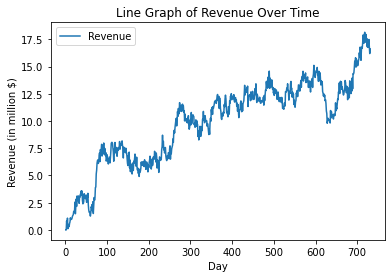

In [3]:
# Plot the time series
df.plot()
plt.title("Line Graph of Revenue Over Time")
plt.ylabel("Revenue (in million $)")
plt.show();

In [4]:
# View column names and data types
print("The last index in the dataframe is", df.index[-1], "and there are", len(df), "records present.")
print("This means that there are no gaps in the time sequence.")

The last index in the dataframe is 731 and there are 731 records present.
This means that there are no gaps in the time sequence.


* The data was provided for each day during the first two years of operation.  There is one record per day for 731 days.  There were no gaps in the time sequence.

In [5]:
# Run stationarity test
result = adfuller(df['Revenue'])

# Print test statistic
print("The t-statistic is:", round(result[0],2))

# Print p-value
print("The p-value is:", round(result[1],2))

# Print critical values
crit_vals = result[4]
print("The critical value of the t-statistic for a 95% confidence level is:", round(crit_vals['5%'],2)) 

The t-statistic is: -1.92
The p-value is: 0.32
The critical value of the t-statistic for a 95% confidence level is: -2.87


* The data was evaluated using the augmented Dickey-Fuller test. This method uses the null-hypothesis that the time series is nonstationary due to trend (Fulton, n.d.). This test returned a t-statistic of -1.92 and a p-value of 0.32. To achieve a confidence level of 95% that we should reject the null hypothesis, the t-statistic should be below -2.87 and the p-value should be below 0.05. Both the results of the t-statistic and the p-value give evidence to reject the null. Therefore, the data will require a transformation to execute the ARIMA model since it is not stationary.

###### Steps for data preparation
Since the ARIMA model can take trends and seasonality into account, I will not transform the data before splitting it into training and test data. The steps that I will take to ensure that the data is prepared for the ARIMA model are:

1. Check data for null values.
2. Add dummy dates of the datetime data type for analysis.
3. Split the data into 80% training and 20% testing data.

#### <u>Step 1</u>

In [6]:
# Look at info to determine if any values are null
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 1 to 731
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


- There are no null values in the dataframe

#### <u>Step 2</u>

In [7]:
# Create one dimensional array
df1 = df.values.flatten()

# Create dummy dates for the Arima modules
dates = pd.date_range('1900-1-1', periods=len(df1), freq='D')

# Add the dates and the data to a new dataframe
ts = pd.DataFrame({'dates': dates, 'Revenue': df1})

# Set the dataframe index to be the dates column
df_ts = ts.set_index('dates')
df_ts.head()

,Revenue
dates,
1900-01-01,0.000000
1900-01-02,0.000793
1900-01-03,0.825542
1900-01-04,0.320332
1900-01-05,1.082554


#### <u>Step 3</u>

In [8]:
# Determine cut off for an 80% training/20% testing data split
cutoff = round(len(df_ts)* 0.8)
cutoff_date = df_ts.iloc[[585]].index.values
Y, M, D, h, m, s = [cutoff_date.astype(f"M8[{x}]") for x in "YMDhms"]

# Print cutoff record and date
print("80% of the data includes", cutoff, "records.")
print ("The date for at index", cutoff, "is:", D)

80% of the data includes 585 records.
The date for at index 585 is: ['1901-08-09']


In [9]:
# Split the data into 80% training and 20% test sets. View tail of training set to make sure it stops at cutoff date.
df_train = df_ts.iloc[:cutoff + 1]
df_test = df_ts.iloc[cutoff + 1:]
df_train.tail(1)

,Revenue
dates,
1901-08-09,13.152903


In [10]:
# Ensure test data starts the day after the cutoff date
df_test.head(1)

,Revenue
dates,
1901-08-10,13.31029


In [11]:
# Ensure the training and test data still contain 731 records total
print("The training and test sets combined contain",len(df_train)+len(df_test), "records.")

The training and test sets combined contain 731 records.


In [12]:
# Save the training, and test sets to Excel files
df_train.to_excel('train.xlsx', index = False, encoding = 'utf-8') 
df_test.to_excel('test.xlsx', index = False, encoding = 'utf-8') 

#### Time Series Analysis

In [13]:
# Calculate the first difference of the time series
df_diff = df.diff().dropna()

In [14]:
# Run stationarity test
result = adfuller(df_diff['Revenue'])

# Print test statistic
print("The t-statistic is:", round(result[0],2))

# Print p-value
print("The p-value is:", round(result[1],2))

# Print critical values
crit_vals = result[4]
print("The critical value of the t-statistic for a 95% confidence level is:", round(crit_vals['5%'],2)) 

The t-statistic is: -44.87
The p-value is: 0.0
The critical value of the t-statistic for a 95% confidence level is: -2.87


- After calculating the difference of the time series, the results of the test statistic and p-value give evidence that the data is now stationary using first difference transformation.

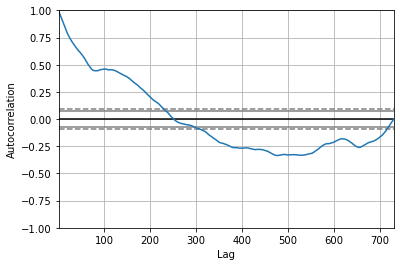

In [16]:
# Check for seasonality with autocorrelation plot
pd.plotting.autocorrelation_plot(df_ts);

- Based on the plot, there does not appear to be any seasonality associated with the data.

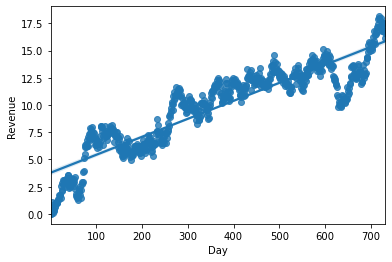

In [17]:
# Display plot to check for trends in data 
sns.regplot(x=df.index,y='Revenue',data=df, fit_reg=True);

- The plot shows that there is an upward positive trend in the data over time.

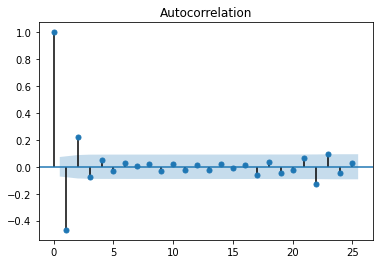

In [18]:
# Plot autocorrelation for 25 lags
plot_acf(df_diff, lags = 25)
plt.show()

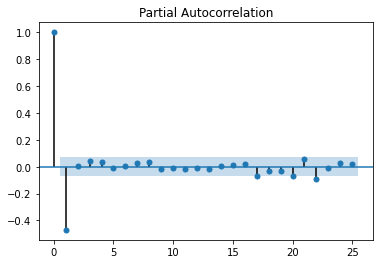

In [19]:
# Plot partial autocorrelation for 25 lags
plot_pacf(df_diff, lags=25)
plt.show()

- The autocorrelation function appears to tail off, while the partial autocorrelation cuts off after one lag.  This suggests that the model will be an AR(p) model.

In [20]:
# Calculate the first difference of the time series so that the data is stationary
df_diff = df.diff().dropna()

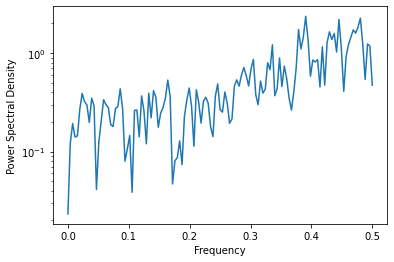

In [21]:
# Plot Power Spectral Density
f, Pxx_den = signal.welch(df_diff['Revenue'])
plt.semilogy(f, Pxx_den)
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.show()

- The power spectral density increases as frequency increases.

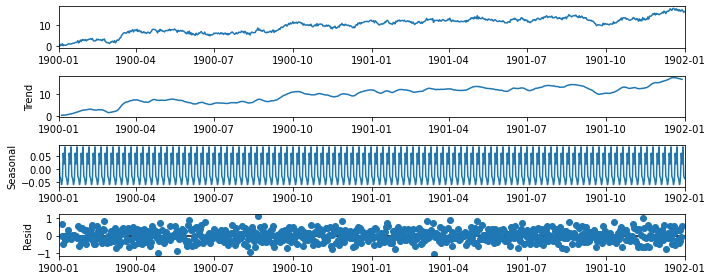

In [22]:
# Plot decomposition
rcParams['figure.figsize'] = 10, 4
decomposition = sm.tsa.seasonal_decompose(df_ts)
fig = decomposition.plot()
plt.show()

- The data shows an upward trend.  The compact consistency of the Seasonal plot shows that the data is not affected by seasonality.  The residuals appear to be random.

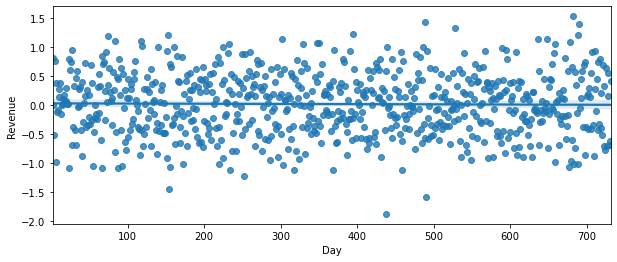

In [23]:
# Display plot to check for trends in data
sns.regplot(x=df_diff.index,y='Revenue',data=df_diff, fit_reg=True);

- The plot shows no trends when used with data transformed using the first difference.

In [24]:
# Determine the ideal values for the AR and MA model

# Create empty list to store search results 
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(3):
  # Loop over q values from 0-2
    for q in range(3):
        # create and fit ARMA(p,q) model
        model = SARIMAX(df_train, order=(p,1,q))
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p,q,results.aic,results.bic))

# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print the top model in order_df in order of increasing AIC
print(order_df.sort_values('AIC').head(1))

# Print the top model in order_df in order of increasing BIC
print(order_df.sort_values('BIC').head(1))

   p  q         AIC         BIC
3  1  0  776.232818  784.976042
   p  q         AIC         BIC
3  1  0  776.232818  784.976042


- Based on both the values of the Akaike information criterion (AIC) and the Bayesian information criterion (BIC), the best model for the data is the ARMA(1,0) model.

In [25]:
# Create and fit ARIMA model based on ARMA(1,0) model and non-stationary data
model = SARIMAX(df_train, order=(1,1,0), trend = 'c')
results = model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))

# Print mean absolute error
print("The mean absolute error is:", round(mae,2))

The mean absolute error is: 0.38


In [26]:
# Print summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  586
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -384.638
Date:                Sat, 20 Nov 2021   AIC                            775.277
Time:                        16:17:26   BIC                            788.392
Sample:                    01-01-1900   HQIC                           780.388
                         - 08-09-1901                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0333      0.019      1.711      0.087      -0.005       0.071
ar.L1         -0.4601      0.036    -12.665      0.000      -0.531      -0.389
sigma2         0.2180      0.014     16.032      0.0

- Since the p-value for the Ljung-Box test (Prob(Q)) is not statistically significant, the residuals are not correlated.  
- The p-value of the Jarque-Bera (Prob(JB)) is also not statistically significant, therefore the residuals are normally distributed.

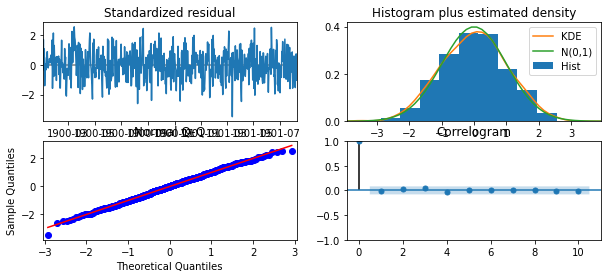

In [27]:
# Create the 4 diagnostic plots
results.plot_diagnostics()
plt.show()

- The Standardized Residual plot shows that there are no obvious patterns in the residuals.
- The Histogram Plus KDE Estimate plot shows that the KDE curve is very close to a normal distribution.
- Normal Q-Q plot shows a pattern where most of the data points reside along the straight line.  The points at the top and bottom of the line where it varies may be due to a few outliers in the data.
- The Correlogram plot shows that 95% of correlations for lag greater than one are not significant.

##### Model Summary

The Akaike information criterion (AIC) and the Bayesian information criterion (BIC) were used to determine the best fit model.  The lower the result for both the AIC and BIC tests, the better the model will fit the data.  Both tests showed that an ARMA(1,0) model is the best fit for the data (Fulton, n.d.).  Since there was no seasonality detected in the previous section, the seasonal order parameter has not been included in the model.  As the original data was not stationary, a value of 1 is used for the degree of differencing to eliminate the upward trend.  Therefore the ARIMA(1,1,0) was determined to be the best model.

#### Forecasting


The comparison of the model predictions to the test data and one year forecast are provided below.

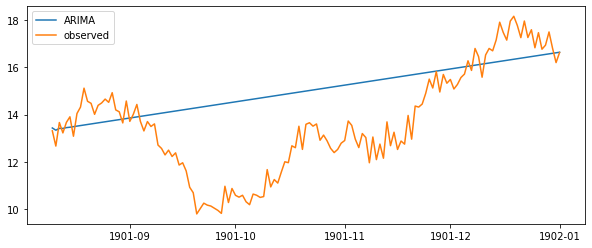

In [28]:
# Create ARIMA mean forecast prediction
arima_test = results.get_forecast(steps=145)
arima_mean = arima_test.predicted_mean

# Plot mean ARIMA predictions and observed for test data
plt.plot(df_test.index, arima_mean, label='ARIMA')
plt.plot(df_test, label='observed')
plt.legend()
plt.show()

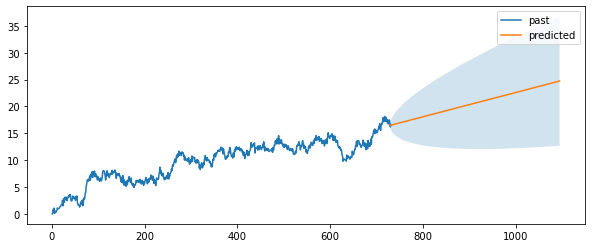

In [29]:
# Plot combined training and testing means with one year forecast

#Create ARMIMA model using complete data set
# Fit model
model = SARIMAX(df, order=(1,1,0), trend = 'c')
results = model.fit()

# Create forecast object for next 365 days
forecast_object = results.get_forecast(steps=365)

# Extract predicted mean attribute
mean = forecast_object.predicted_mean

# Calculate the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index
plt.figure()

# Plot past Revenue levels
plt.plot(df.index, df, label='past')

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.show()

#### Results

The selection of an ARIMA model was based on a search of parameters with the best AIC and BIC scores.  Seasonal order did not need to be included in the parameters of the model.  Also, the first difference was used due to the results of the augmented Dickey-Fuller test performed in section D1.  I did choose a trend parameter of "continuous", as it appears that the data will continue to trend upward so it made sense to see that in future predictions.

The prediction confidence interval was calculated using the conf_int() function on the object created using the get_forecast() function of the ARIMA model.  The interval is the area that we expect the Revenue to be on a given day.  As the forecasted date gets farther from the original dataset, the interval becomes wider.  This means that as time goes on, it is harder to predict what the Revenue will be.

The model residuals had a very low mean absolute error of 0.38, meaning that they are very close to the expected Revenue.  The model summary showed that the residuals were not correlated and were normally distributed.  The diagnostic plots showed further evidence that the model was a good fit in that: 

> - The Standardized Residual plot shows that there are no obvious patterns in the residuals.
> - The Histogram Plus KDE Estimate plot shows that the KDE curve is very close to a normal distribution.
> - The Normal Q-Q plot shows a pattern where most of the data points reside along the straight line. The points at the top and bottom of the line where it varies may be due to a few outliers in the data.
> - The Correlogram plot shows that 95% of correlations for lag greater than one are not significant.

Based on the continued expected upward trend, I would recommend that the stakeholders of the telecommunications company continue their churn mitigation efforts. I would also suggest that they continue to look for new cost-effective methods that can add to their customer base. The combined efforts of both actions should ensure that the upward revenue trend continues.

#### Sources

- Bowne-Anderson, H. (2018, January 17). Python time series Analysis Tutorial. Retrieved March 07, 2021, from https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

- Fulton, J. (n.d.). ARIMA Models in Python. Retrieved March 2, 2021, from 
https://learn.datacamp.com/courses/arima-models-in-python

- Jones, E., Oliphant, T., Peterson, P. & others (2001). SciPy: Open source scientific tools for Python. Retrieved March 07, 2021, from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html

#### Helpful Sites Used in Coding Project

1. https://learn.datacamp.com/courses/arima-models-in-python
2. https://stackoverflow.com/questions/49211611/using-statsmodel-arima-without-dates
3. https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial
4. https://stackoverflow.com/questions/54308172/adding-a-trend-line-to-a-matplotlib-line-plot-python
5. https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html